Используя базу данных автомобилей, создайте сеть с точностью распознавания не ниже 93% на проверочной выборке.

Для решения задачи вы можете использовать любой подход:
- модель без аугментации данных
- аугментация данных с помощью ImageDataGenerator
- аугментация данных с помощью самописного генератора изображений
- использовать готовую архитектуру из набора `tf.keras.applications` (Обратите внимание: на занятии мы не рассматривали данный модуль фреймворка Керас. Ваша задача: попробовать самостоятельно разобраться в приципах его работы. В разборе домашнего задания вы получите ссылку на ноутбук Базы Знаний УИИ, где подробно раскрывается вопрос использования готовых архитектур)

In [ ]:
import gdown
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dropout,
    BatchNormalization,
    Input,
    Activation,
    GlobalAveragePooling2D,
    LeakyReLU,
)

# оптимизатор Adam и SGD
from tensorflow.keras.optimizers import Adam, SGD

# Импорт предварительно обученной модели VGG19 из Keras
from tensorflow.keras.applications import VGG19

# Импорт генератора изображений, который используется для увеличения обучающего набора данных с помощью аугментации
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Загрузка zip-архива с датасетом из облака на диск виртуальной машины colab
gdown.download(
    "https://storage.yandexcloud.net/aiueducation/Content/base/l5/middle_fmr.zip",
    None,
    quiet=True,
    )

'middle_fmr.zip'

In [ ]:
os.mkdir("cars")
# Распаковка zip-архива с датасетом из облака на диск виртуальной машины colab
!unzip -qo "middle_fmr.zip" -d cars/cars_train

FileExistsError: [Errno 17] File exists: 'cars'

In [ ]:
# Размер деления выборки на тестовую, проверочную и обучающую
TEST_SPLIT = VAL_SPLIT = 0.1
TRAIN_PATH = Path("cars/cars_train")
VAL_PATH = Path("cars/cars_val")
TEST_PATH = Path("cars/cars_test")

if not (TEST_PATH.exists() and VAL_PATH.exists()):
    TEST_PATH.mkdir(exist_ok=True)
    VAL_PATH.mkdir(exist_ok=True)

    for classfolder in TRAIN_PATH.iterdir():
        classfolder_test = TEST_PATH / classfolder.name
        classfolder_val = VAL_PATH / classfolder.name

        classfolder_test.mkdir(exist_ok=True)
        classfolder_val.mkdir(exist_ok=True)

        files = list(classfolder.iterdir())
        len_class = len(files)
        test_len = int(len_class * TEST_SPLIT)
        val_len = int(len_class * VAL_SPLIT)

        for i, img in enumerate(files):
            if i < test_len:
                img.rename(classfolder_test / img.name)
            elif i < test_len + val_len:
                img.rename(classfolder_val / img.name)
            else:
                break


In [ ]:
# Аугументация и нормализация данных
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.05,
    zoom_range=0.2,
    brightness_range=(0.7, 1.3),
    horizontal_flip=True,
    rescale=1.0 / 255.0,
)

test_and_val_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
)


In [ ]:
# Параметры изображения
IMG_HEIGHT = 108
IMG_WIDTH = 192
BATCH_SIZE = 64

In [ ]:
# Обучающая выборка генерируется из папки обучающего набора
train_generator = train_datagen.flow_from_directory(
    # Путь к обучающим изображениям
    TRAIN_PATH,
    # Параметры требуемого размера изображения
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    # Размер батча
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
)

# Проверочная выборка генерируется из папки проверочного набора
validation_generator = test_and_val_datagen.flow_from_directory(
    VAL_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
)

# Тестовая выборка генерируется из папки тестового набора
test_generator = test_and_val_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
)

Found 2745 images belonging to 3 classes.
Found 341 images belonging to 3 classes.
Found 341 images belonging to 3 classes.


In [ ]:
print("Распределение изображений для классов, обучающей выборки:", np.bincount(train_generator.classes))
print("Распределение изображений для классов, проверочной выборки:", np.bincount(validation_generator.classes))
print("Распределение изображений для классов, тестовой выборки:", np.bincount(test_generator.classes))


Распределение изображений для классов, обучающей выборки: [872 929 944]
Распределение изображений для классов, проверочной выборки: [108 116 117]
Распределение изображений для классов, тестовой выборки: [108 116 117]


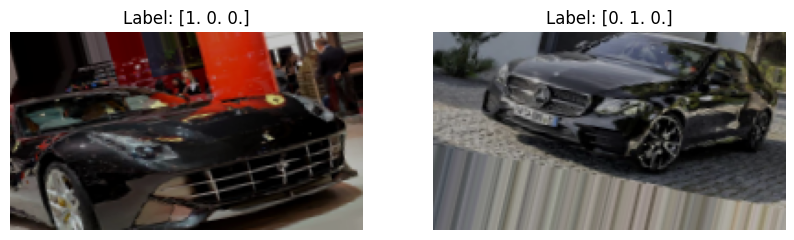

In [ ]:
# Получаем один батч изображений и меток из генератора
images, labels = next(train_generator)

# Выводим первые несколько изображений из батча
num_images_to_show = 2
plt.figure(figsize=(10, 5))

for i in range(num_images_to_show):
    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {labels[i]}")
    plt.axis("off")

plt.show()

In [ ]:
# Для создания модели используем готовую архитектуру vgg19

# Загружаем модель VGG19 без верхних слоев (головы), с предобученными весами ImageNet
base_model = VGG19(
    weights="imagenet", include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

# Замораживаем все слои базовой модели (чтобы не обучались)
for layer in base_model.layers:
    layer.trainable = False

# Размораживаем последние 5 слоев для дообучения
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Создаем модель на основе VGG19 с добавлением своих слоев классификации
model_vgg = Sequential(
    [
        base_model,                     # Базовая модель VGG19
        GlobalAveragePooling2D(),       # Глобальный усредняющий пуллинг
        Dropout(0.6),                   # Dropout
        Dense(512, activation="relu"),  # Полносвязный слой с ReLU
        Dropout(0.6),                   # Dropout
        Dense(3, activation="softmax")  # Выходной слой для 3 классов
    ]
)

# Компиляция модели с оптимизатором SGD и функцией потерь для многоклассовой классификации.
model_vgg.compile(
    # optimizer=Adam(learning_rate=0.00001),  # альтернативный оптимизатор (закомментирован)
    optimizer=SGD(learning_rate=0.003, momentum=0.9),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [ ]:
# Выведем структуру и параметры
model_vgg.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 3, 6, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,288,579 (77.39 MB)

 Trainable params: 9,703,427 (37.02 MB)

 Non-trainable params: 10,585,152 (40.38 MB)

In [ ]:
# Обучим полученную модель
history_vgg = model_vgg.fit(
    train_generator,
    epochs=150,
    validation_data=validation_generator,
    verbose=1,
)

Epoch 1/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 30s 623ms/step - accuracy: 0.3449 - loss: 1.2925 - val_accuracy: 0.5484 - val_loss: 1.0763
Epoch 2/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 500ms/step - accuracy: 0.4160 - loss: 1.0622 - val_accuracy: 0.5660 - val_loss: 0.8664
Epoch 3/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 516ms/step - accuracy: 0.5551 - loss: 0.9139 - val_accuracy: 0.6158 - val_loss: 0.8235
Epoch 4/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 511ms/step - accuracy: 0.6155 - loss: 0.8228 - val_accuracy: 0.7771 - val_loss: 0.5708
Epoch 5/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 519ms/step - accuracy: 0.7251 - loss: 0.6853 - val_accuracy: 0.8152 - val_loss: 0.4455
Epoch 6/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 503ms/step - accuracy: 0.7769 - loss: 0.5714 - val_accuracy: 0.8152 - val_loss: 0.5319
Epoch 7/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 42s 517ms/step - accuracy: 0.7452 - loss: 0.6268 - val_accuracy: 0.7947 - val_loss: 0.4582
Epoch 8/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 40s 502ms/step - accuracy: 0.8071 - loss: 0.5227 - 

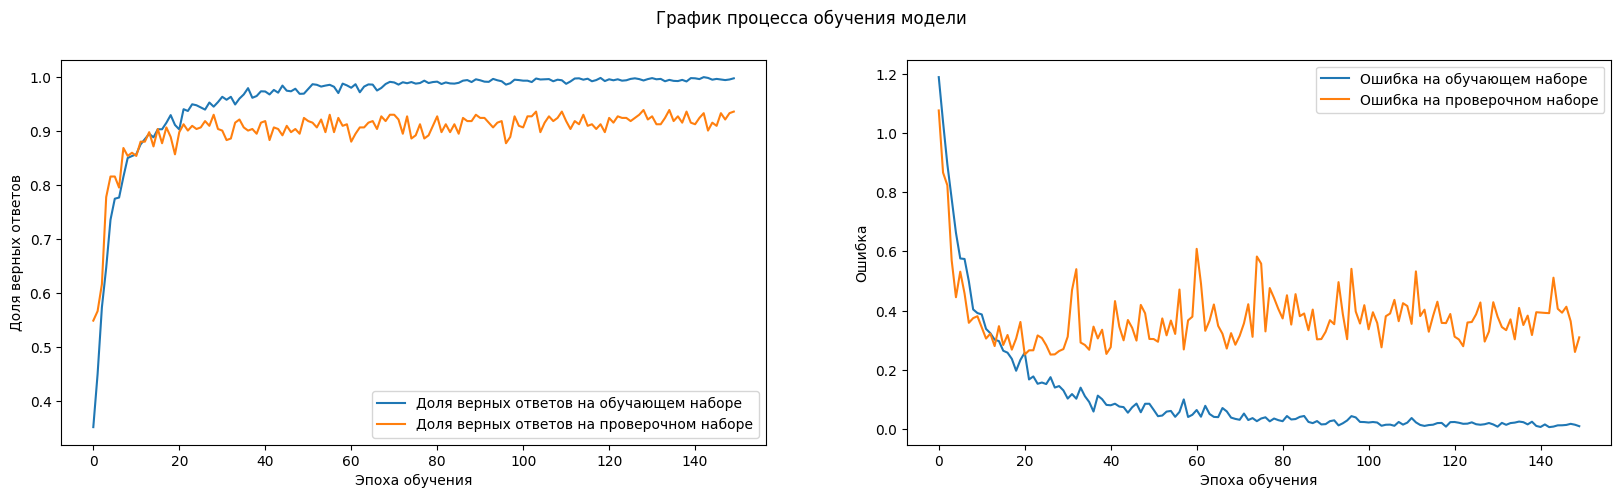

In [ ]:
# Визуализируем ход обучения модели

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle("График процесса обучения модели")
ax1.plot(history_vgg.history["accuracy"], label="Доля верных ответов на обучающем наборе")
ax1.plot(
    history_vgg.history["val_accuracy"], label="Доля верных ответов на проверочном наборе"
)
ax1.xaxis.get_major_locator().set_params(integer=True)
ax1.set_xlabel("Эпоха обучения")
ax1.set_ylabel("Доля верных ответов")
ax1.legend()

ax2.plot(history_vgg.history["loss"], label="Ошибка на обучающем наборе")
ax2.plot(history_vgg.history["val_loss"], label="Ошибка на проверочном наборе")
ax2.xaxis.get_major_locator().set_params(integer=True)
ax2.set_xlabel("Эпоха обучения")
ax2.set_ylabel("Ошибка")
ax2.legend()
plt.show()


In [ ]:
_, test_acc = model_vgg.evaluate(test_generator)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - accuracy: 0.9141 - loss: 0.4854


In [ ]:
print(
    f"Точность на обучающей выборке: {history_vgg.history['accuracy'][-1] * 100:.2f},\n"
    f"точность на проверочной выборке: {history_vgg.history['val_accuracy'][-1] * 100:.2f},\n"
    f"точность на тестовой выборке: {test_acc * 100:.2f}."
)

Точность на обучающей выборке: 99.71,
точность на проверочной выборке: 93.55,
точность на тестовой выборке: 91.50.
